<a href="https://colab.research.google.com/github/paulantoine/covid_dept/blob/master/covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import requests
import bs4 as BeautifulSoup
import matplotlib.pyplot as plt
#import seaborn as sns
plt.style.use('fivethirtyeight') #'seaborn-notebook'
#plt.rcParams.update({'font.size': 14})il

In [ ]:
def read_data(url, dataset_name, sep=","):
    r = requests.get(url)
    soup = BeautifulSoup.BeautifulSoup(r.text)
    ressources_list = soup.find("div", "resources-list")
    url = None
    for article in ressources_list.find_all("article"):
      if dataset_name in article.div.h4.text:
        url = article.find("a", "btn btn-sm btn-primary", download=True)["href"]
        break
    if url == None:
      raise("data not found")
    return pd.read_csv(url, sep=sep)
    
df = read_data(
    "https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/",
    "donnees-hospitalieres-nouveaux-covid19",
    ";"
)

df.tail()

,dep,jour,incid_hosp,incid_rea,incid_dc,incid_rad
9893,976,2020-06-20,6,0,0,7
9894,976,2020-06-21,3,2,1,1
9895,976,2020-06-22,10,2,0,7
9896,976,2020-06-23,4,1,0,10
9897,976,2020-06-24,3,0,1,1


In [ ]:
def display_df(df, title, logscale=False):
    """
    df a pour index les jours et les cols ["incid_hosp", "incid_rea"]
    """
    daily = df[["incid_hosp", "incid_rea"]]
    lissage_hebdo = daily.rolling(7, center=True).mean()
    lissage_hebdo.columns = ["hosp_lisse", "rea_lisse"]

    # désaisonalisation
    if daily["incid_hosp"].min() > 5:
        modele_hebdo = daily.iloc[-7:,:].to_numpy() + daily.iloc[-14:-7,:].to_numpy() + daily.iloc[-21:-14,:].to_numpy()
        modele_hebdo = modele_hebdo + np.array([np.arange(-3,4), np.zeros(7)]).T * (daily.iloc[-21:-14, 0].mean()- daily.iloc[-7:,0].mean()) / 14 
        modele_hebdo =  modele_hebdo / modele_hebdo.mean(axis=0)
        desaiso = pd.concat([daily.iloc[-7*i -7 : -7*i ]/modele_hebdo for i in range(4,0,-1)] + [daily.iloc[-7:,:]/modele_hebdo]).rolling(3, center=True).mean()
        desaiso.columns = ["hosp_desaiso", "rea_desaiso"]
        dept = pd.concat([daily, lissage_hebdo, desaiso], axis=1)
        cols = ["incid_hosp",  "hosp_lisse", "hosp_desaiso", "incid_rea"]
        legend = ["hospitalisations", "hospitalisation lissées 7j", "hospitalisations déshebdomadérisées", "réanimation"]
        disp = ["incid_hosp", "incid_rea", "hosp_desaiso"]
    else:
        dept = pd.concat([daily, lissage_hebdo], axis=1)
        cols = ["incid_hosp",  "hosp_lisse",  "incid_rea"]
        legend = ["hospitalisations", "hospitalisation lissées 7j", "réanimation"]
        disp = ["incid_hosp", "incid_rea", "hosp_lisse"]

    plt.figure(figsize=(15,8))
    if logscale:
        plt.yscale('log')
    plt.plot(dept[cols], marker="o")
    plt.xticks(rotation=75)
    plt.title(title, fontsize=22)
    plt.legend(legend, loc=1, fontsize=14)
    plt.show()
    print("\ndernières données : \n")
    print(dept[disp].apply(np.rint).tail(8))

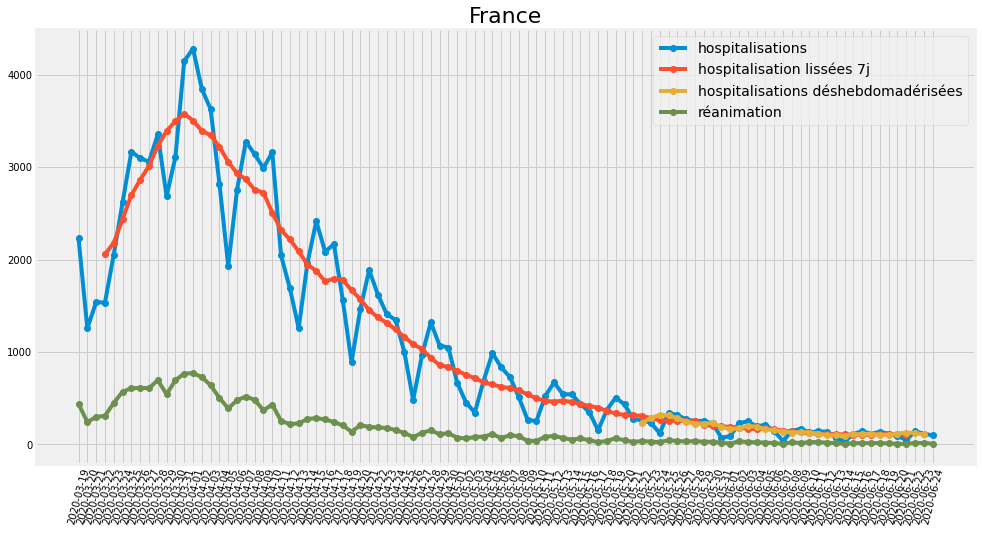


dernières données : 

            incid_hosp  incid_rea  hosp_desaiso
2020-06-17       116.0       14.0         115.0
2020-06-18       136.0       15.0         105.0
2020-06-19       116.0       10.0         102.0
2020-06-20        90.0        7.0         116.0
2020-06-21        48.0        5.0         128.0
2020-06-22       142.0       16.0         124.0
2020-06-23       117.0       15.0         108.0
2020-06-24        97.0        8.0           NaN


In [ ]:
display_df(df.groupby(["jour"])[["incid_hosp", "incid_rea"]].sum(), "France")


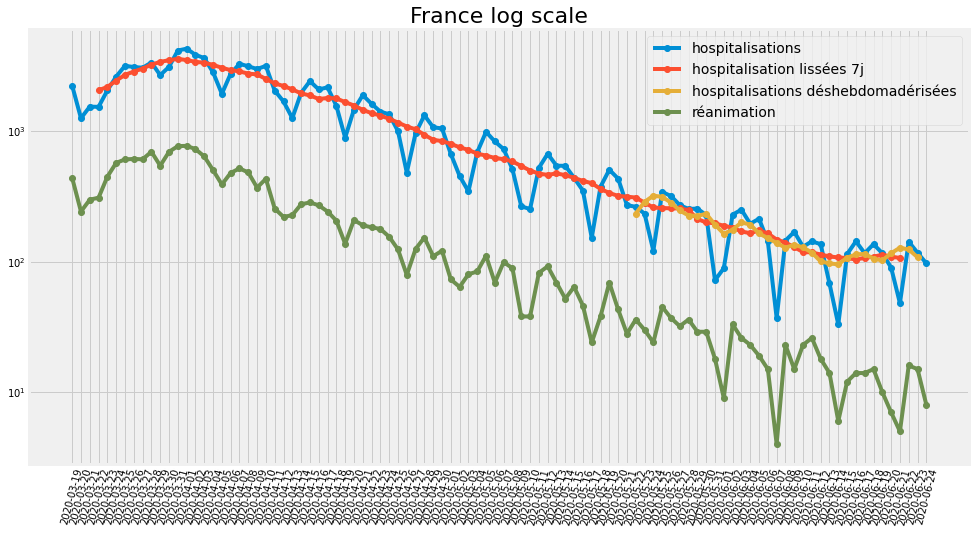


dernières données : 

            incid_hosp  incid_rea  hosp_desaiso
2020-06-17       116.0       14.0         115.0
2020-06-18       136.0       15.0         105.0
2020-06-19       116.0       10.0         102.0
2020-06-20        90.0        7.0         116.0
2020-06-21        48.0        5.0         128.0
2020-06-22       142.0       16.0         124.0
2020-06-23       117.0       15.0         108.0
2020-06-24        97.0        8.0           NaN


In [ ]:
display_df(df.groupby(["jour"])[["incid_hosp", "incid_rea"]].sum(), "France log scale", logscale=True)


In [ ]:
def display_dept(d_number, d_name):
    dept = df[df.dep==d_number]
    dept.set_index(dept.jour, inplace=True)

    daily = dept[["incid_hosp", "incid_rea"]]
    lissage_hebdo = daily.rolling(7, center=True).mean()
    lissage_hebdo.columns = ["hosp_lisse", "rea_lisse"]

    # désaisonalisation
    if dept["incid_hosp"].min() > 5:
        modele_hebdo = daily.iloc[-7:,:].to_numpy() + daily.iloc[-14:-7,:].to_numpy() + daily.iloc[-21:-14,:].to_numpy()
        modele_hebdo = modele_hebdo + np.array([np.arange(-3,4), np.zeros(7)]).T * (daily.iloc[-21:-14, 0].mean()- daily.iloc[-7:,0].mean()) / 14 
        modele_hebdo =  modele_hebdo / modele_hebdo.mean(axis=0)
        desaiso = pd.concat([daily.iloc[-7*i -7 : -7*i ]/modele_hebdo for i in range(4,0,-1)] + [daily.iloc[-7:,:]/modele_hebdo]).rolling(3, center=True).mean()
        desaiso.columns = ["hosp_desaiso", "rea_desaiso"]
        dept = pd.concat([daily, lissage_hebdo, desaiso], axis=1)
        cols = ["incid_hosp",  "hosp_lisse", "hosp_desaiso", "incid_rea"]
        legend = ["hospitalisations", "hospitalisation lissées 7j", "hospitalisations déshebdomadérisées", "réanimation"]
    else:
        dept = pd.concat([daily, lissage_hebdo], axis=1)
        cols = ["incid_hosp",  "hosp_lisse",  "incid_rea"]
        legend = ["hospitalisations", "hospitalisation lissées 7j", "réanimation"]

    plt.figure(figsize=(15,8))
    plt.plot(dept[cols], marker="o")
    plt.xticks(rotation=75)
    plt.title(d_name, fontsize=22)
    plt.legend(legend, loc=1, fontsize=14)
    plt.show()
    print("\ndernières données lissées 7j: \n")
    print(dept.rolling(7).mean().apply(np.rint).tail())
    

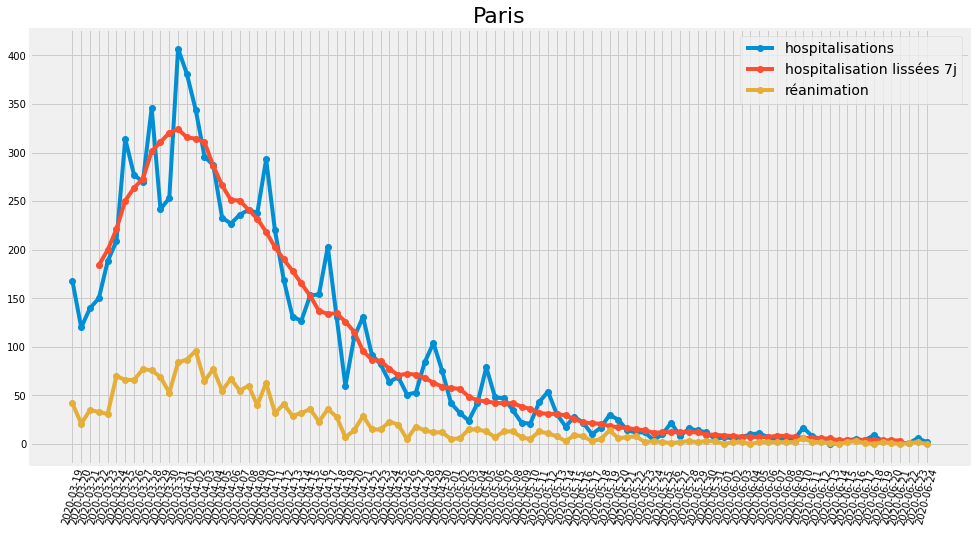


dernières données : 

            incid_hosp  incid_rea  hosp_lisse
jour                                         
2020-06-17         4.0        1.0         4.0
2020-06-18         9.0        0.0         4.0
2020-06-19         3.0        2.0         4.0
2020-06-20         3.0        1.0         4.0
2020-06-21         1.0        0.0         4.0
2020-06-22         1.0        1.0         NaN
2020-06-23         6.0        2.0         NaN
2020-06-24         2.0        0.0         NaN


In [ ]:
display_df(df[df.dep=="75"].set_index("jour", drop=True), "Paris")

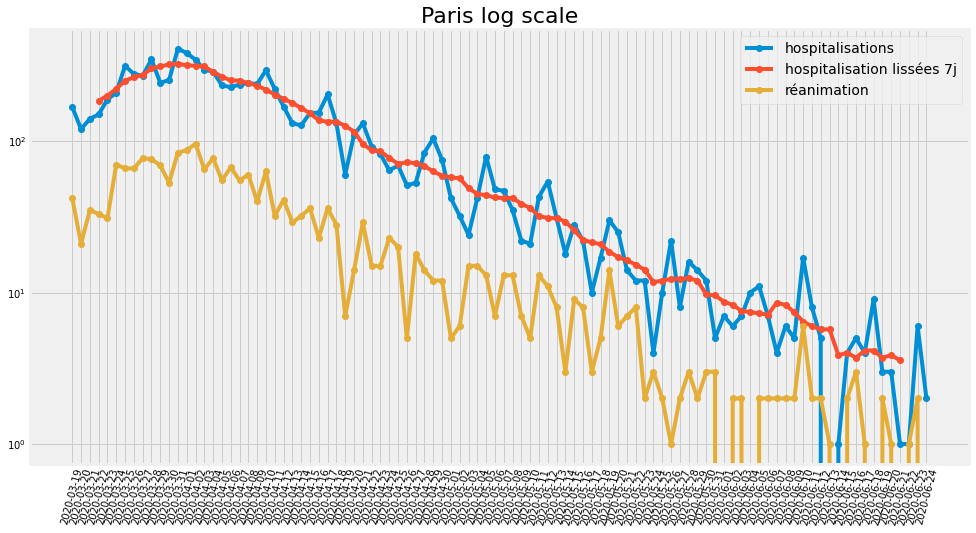


dernières données : 

            incid_hosp  incid_rea  hosp_lisse
jour                                         
2020-06-17         4.0        1.0         4.0
2020-06-18         9.0        0.0         4.0
2020-06-19         3.0        2.0         4.0
2020-06-20         3.0        1.0         4.0
2020-06-21         1.0        0.0         4.0
2020-06-22         1.0        1.0         NaN
2020-06-23         6.0        2.0         NaN
2020-06-24         2.0        0.0         NaN


In [ ]:
display_df(df[df.dep=="75"].set_index("jour", drop=True), "Paris log scale", True)

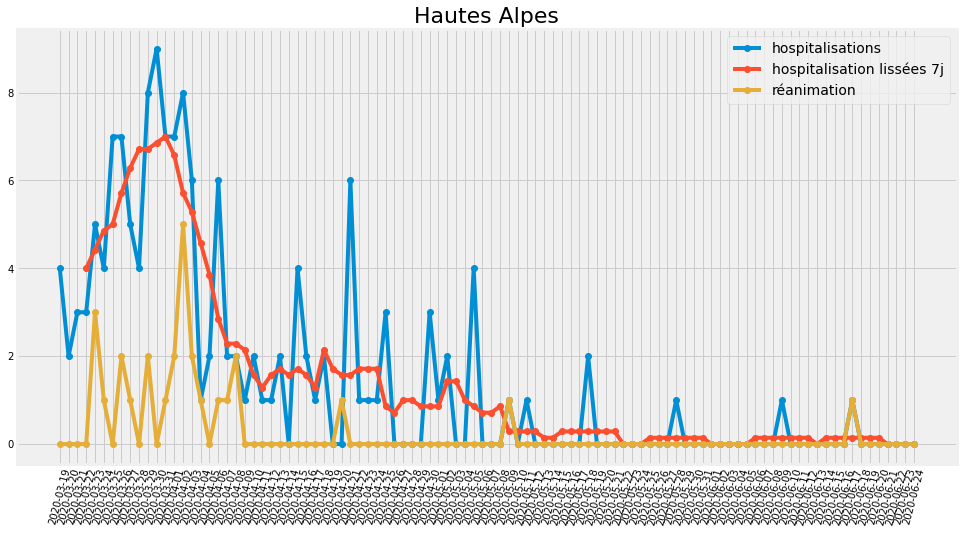


dernières données : 

            incid_hosp  incid_rea  hosp_lisse
jour                                         
2020-06-17         1.0        1.0         0.0
2020-06-18         0.0        0.0         0.0
2020-06-19         0.0        0.0         0.0
2020-06-20         0.0        0.0         0.0
2020-06-21         0.0        0.0         0.0
2020-06-22         0.0        0.0         NaN
2020-06-23         0.0        0.0         NaN
2020-06-24         0.0        0.0         NaN


In [ ]:
display_df(df[df.dep=="05"].set_index("jour", drop=True),"Hautes Alpes")

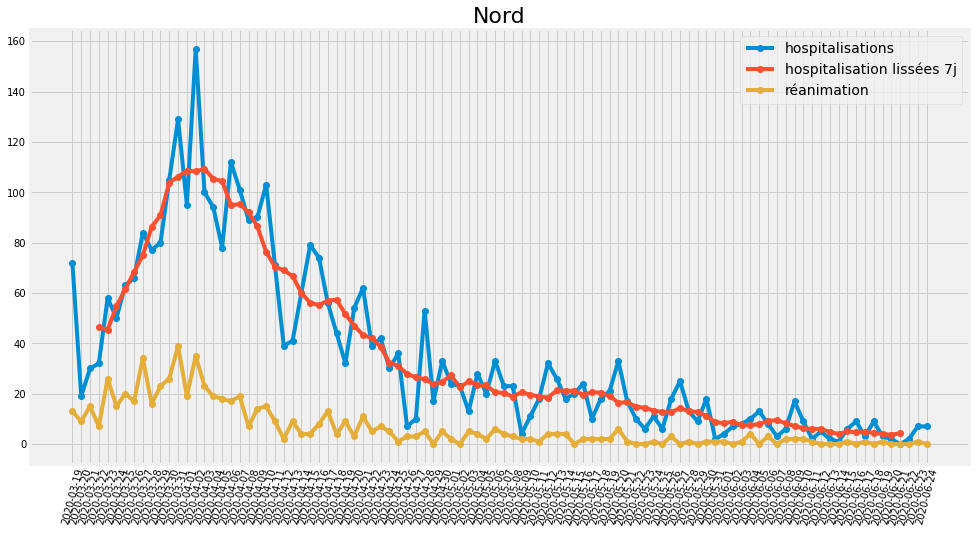


dernières données : 

            incid_hosp  incid_rea  hosp_lisse
jour                                         
2020-06-17         3.0        1.0         5.0
2020-06-18         9.0        0.0         5.0
2020-06-19         3.0        1.0         4.0
2020-06-20         2.0        0.0         4.0
2020-06-21         0.0        0.0         4.0
2020-06-22         2.0        0.0         NaN
2020-06-23         7.0        1.0         NaN
2020-06-24         7.0        0.0         NaN


In [ ]:
display_df(df[df.dep=="59"].set_index("jour", drop=True),"Nord")

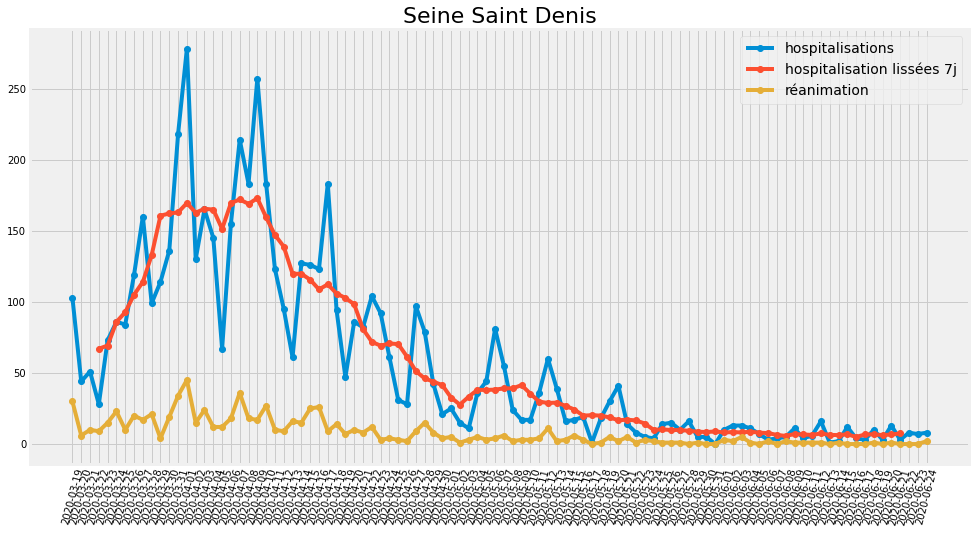


dernières données : 

            incid_hosp  incid_rea  hosp_lisse
jour                                         
2020-06-17         3.0        0.0         7.0
2020-06-18        10.0        1.0         7.0
2020-06-19         3.0        0.0         6.0
2020-06-20        13.0        1.0         7.0
2020-06-21         3.0        0.0         7.0
2020-06-22         8.0        0.0         NaN
2020-06-23         7.0        0.0         NaN
2020-06-24         8.0        2.0         NaN


In [ ]:
display_df(df[df.dep=="93"].set_index("jour", drop=True),"Seine Saint Denis")

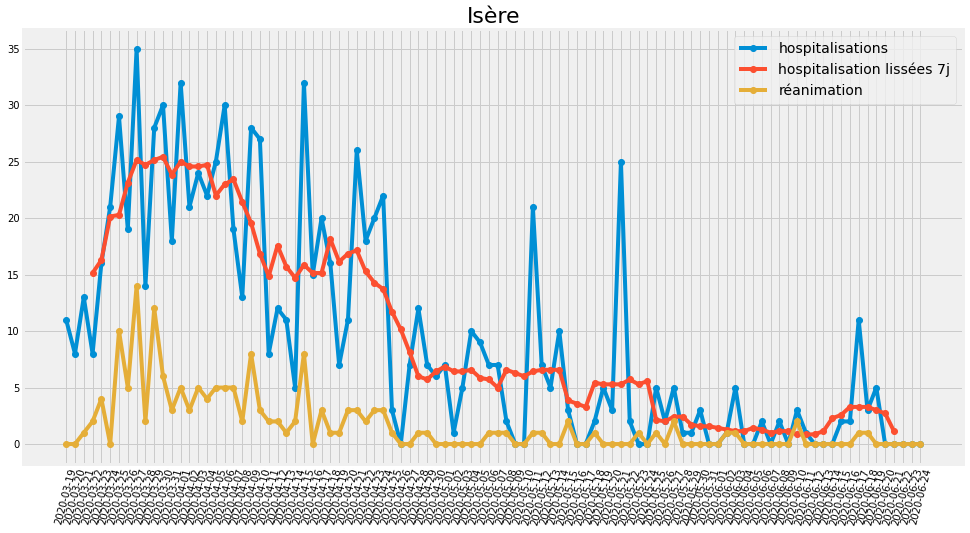


dernières données : 

            incid_hosp  incid_rea  hosp_lisse
jour                                         
2020-06-17        11.0        1.0         3.0
2020-06-18         3.0        1.0         3.0
2020-06-19         5.0        0.0         3.0
2020-06-20         0.0        0.0         3.0
2020-06-21         0.0        0.0         1.0
2020-06-22         0.0        0.0         NaN
2020-06-23         0.0        0.0         NaN
2020-06-24         0.0        0.0         NaN


In [ ]:
display_df(df[df.dep=="38"].set_index("jour", drop=True),"Isère")

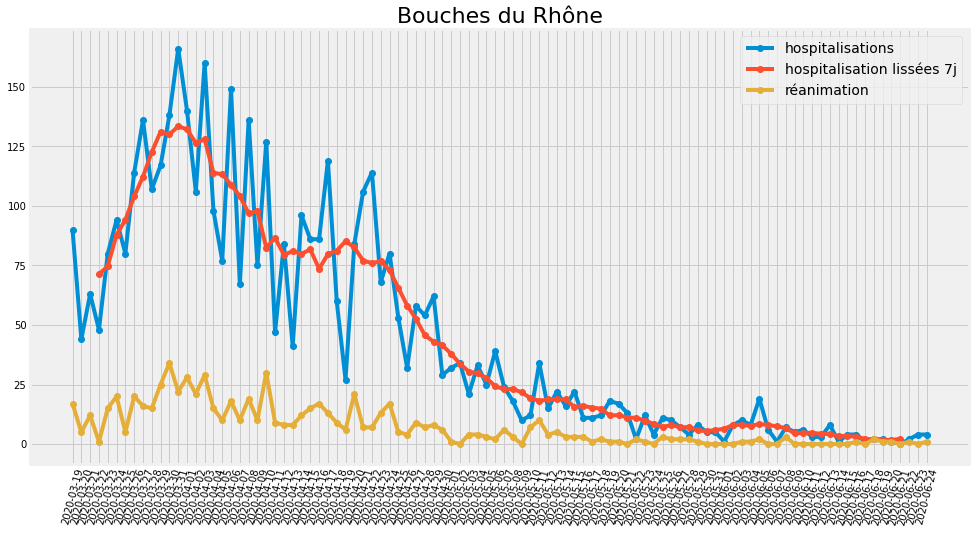


dernières données : 

            incid_hosp  incid_rea  hosp_lisse
jour                                         
2020-06-17         1.0        0.0         2.0
2020-06-18         2.0        2.0         2.0
2020-06-19         2.0        1.0         2.0
2020-06-20         1.0        1.0         2.0
2020-06-21         0.0        0.0         2.0
2020-06-22         2.0        1.0         NaN
2020-06-23         4.0        0.0         NaN
2020-06-24         4.0        1.0         NaN


In [ ]:
display_df(df[df.dep=="13"].set_index("jour", drop=True),"Bouches du Rhône")

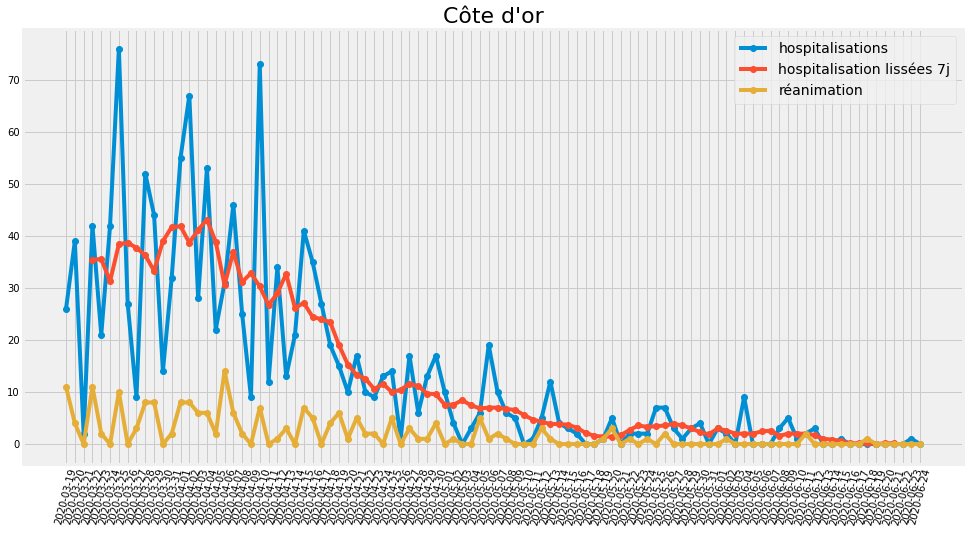


dernières données : 

            incid_hosp  incid_rea  hosp_lisse
jour                                         
2020-06-17         0.0        0.0         0.0
2020-06-18         0.0        1.0         0.0
2020-06-19         0.0        0.0         0.0
2020-06-20         0.0        0.0         0.0
2020-06-21         0.0        0.0         0.0
2020-06-22         0.0        0.0         NaN
2020-06-23         1.0        0.0         NaN
2020-06-24         0.0        0.0         NaN


In [ ]:
display_df(df[df.dep=="21"].set_index("jour", drop=True),"Côte d'or")

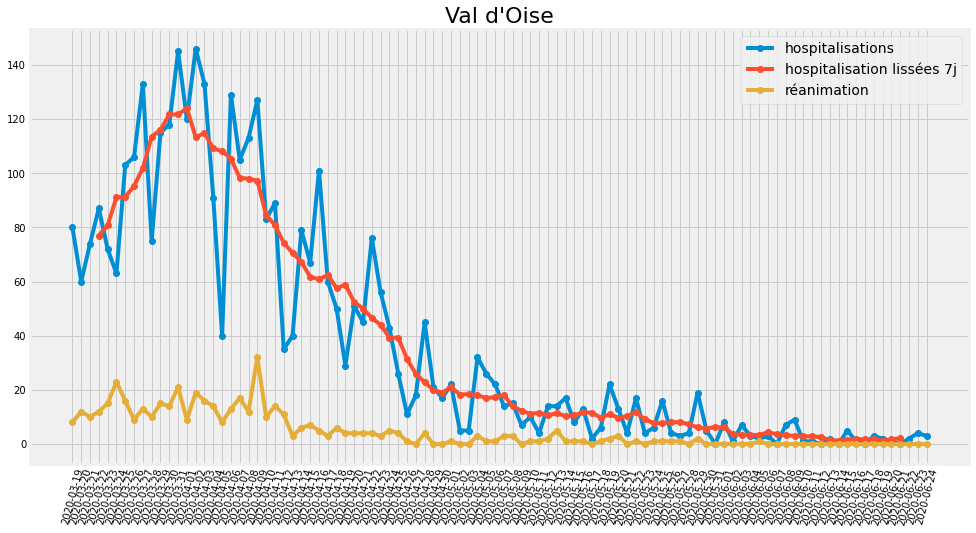


dernières données : 

            incid_hosp  incid_rea  hosp_lisse
jour                                         
2020-06-17         0.0        0.0         2.0
2020-06-18         3.0        0.0         2.0
2020-06-19         2.0        0.0         1.0
2020-06-20         1.0        0.0         2.0
2020-06-21         0.0        0.0         2.0
2020-06-22         2.0        0.0         NaN
2020-06-23         4.0        0.0         NaN
2020-06-24         3.0        0.0         NaN


In [ ]:
display_df(df[df.dep=="95"].set_index("jour", drop=True),"Val d'Oise")

In [ ]:
cumul = read_data(
    "https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/",
    "donnees-hospitalieres-covid19",
    ";"
)

c = cumul.groupby(["dep", "jour"])["hosp", "rea"].sum().reset_index()
c.tail()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


,dep,jour,hosp,rea
9994,976,2020-06-20,74,16
9995,976,2020-06-21,74,18
9996,976,2020-06-22,80,22
9997,976,2020-06-23,68,18
9998,976,2020-06-24,74,14


In [ ]:
import datetime
from datetime import datetime


In [ ]:

s1 = '21:56:01'
s2 = '22:33:24' # for example
FMT = '%H:%M:%S'
tdelta = datetime.strptime(s2, FMT) - datetime.strptime(s1, FMT)
tdelta

datetime.timedelta(0, 2243)